In [63]:
import numpy as np
import pandas as pd
import usbtmc
from matplotlib import pyplot as plt
import struct
import time
from scipy.signal import find_peaks
import ipywidgets as widgets
from ipywidgets import interact_manual

In [83]:
instr=usbtmc.Instrument(6833,1416)
print(instr.ask("*IDN?"))
print(instr.ask(":CHAN1:MEMD?"))

Rigol Technologies,DS1102E,DS1ET194510708,00.04.02.01.00
1048576


Sample rate 5000000.000000
voltage scale is 0.520000
number of samples:524277.000000
min freq(precision): 9.536943
max freq: 4999990.463057
         freq(Hz)  strength         dB  rel_freq
30    3786.166473  0.270617 -31.352914  1.000000
59    7562.796003  0.222305 -33.061004  1.997481
87   11348.962476  0.170145 -35.383593  2.997481
115  15135.128949  0.084295 -41.484012  3.997481
223  30260.720955  0.055361 -45.135962  7.992443
197  26474.554482  0.046973 -46.562945  6.992443
143  18911.758479  0.041655 -47.606571  4.994962
250  34046.887428  0.040898 -47.765929  8.992443
171  22697.924952  0.036796 -48.684005  5.994962
278  37823.516958  0.023043 -52.749216  9.989924


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


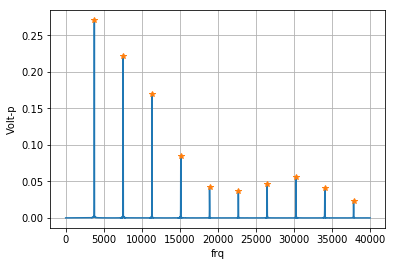

In [60]:
def hamming(n,L):
    return 0.54-0.46*np.cos(2*np.pi*n/(L-1))
peak_distance=100 #Hz
max_plot_v= 40 #kHz
Z0=50.0 #ohm

instr.ask(":STOP",wait_reply=False)

samp_rate=np.float(instr.ask(':ACQ:SAMP?'))
print('Sample rate %f'%samp_rate)
time.sleep(0.1)
volt_scale=np.float(instr.ask(':CHAN1:SCAL?'))
print('voltage scale is %f'%volt_scale)
time.sleep(0.1)
#print('MemDepth %f'%instr.ask('ACQ:MEMD?'))
time.sleep(2.0)

# for some strange reasons we are better of if we :RUN first!
instr.ask(":RUN",wait_reply=False)
raw_data=instr.ask_raw(b":WAV:DATA? CHAN1")

data=struct.unpack("B"*len(raw_data),raw_data)

#greeing rid of meta-data
data=data[20:-1]

#taking caring of Rigole craziness!
data=(255-np.array(data))*volt_scale/25

print('number of samples:%f'%len(data))
total_acq_time=len(data)/samp_rate
omega=np.arange(0,len(data))*2*np.pi/total_acq_time
print ("min freq(precision): %f"%(omega[1]/2/np.pi))
print ("max freq: %f"%(omega[-1]/2/np.pi))
n_max_plot=np.int(max_plot_v/omega[1]*2*np.pi*1000)
n_distance=np.int(peak_distance/omega[1]*2*np.pi)+1
ham_mask=hamming(np.arange(0,len(data)),len(data))
f=np.fft.fft(data*ham_mask)/len(data)
f_max=np.abs(f[1:]).max()
useful_f=np.abs(f[2:n_max_plot])
useful_o=omega[2:n_max_plot]
peaks=find_peaks(useful_f,distance=n_distance)[0]                
plt.plot(useful_o/2/np.pi,useful_f*2) #*2 because we want "peak" voltages,sum of two + - freq components
plt.xlabel('frq')
plt.ylabel('Volt-p')
plt.grid()
#print(omega[peaks-1]/2/np.pi,useful_f[peaks])
peaks_frame=pd.DataFrame(np.array([useful_o[peaks]/2/np.pi,useful_f
                                   [peaks]*2,20*np.log10(np.sqrt(2.0/Z0)*useful_f[peaks])]).T,columns=['freq(Hz)','strength','dB'])
peaks_frame=peaks_frame.sort_values(by=['strength'],ascending=False)
#print(peaks_frame[:10])
some_peaks=peaks_frame[:min(10,np.shape(peaks_frame)[0])]
some_peaks['rel_freq']=some_peaks['freq(Hz)']/some_peaks['freq(Hz)'].iloc[0]
print(some_peaks)
plt.plot(some_peaks['freq(Hz)'],some_peaks['strength'],'*')

In [76]:
instr.ask(":RUN",wait_reply=0)

0

In [101]:
@interact_manual
def measure(peak_distance=[10,100,1000,10000],max_plot=(3,9,0.5),channel=[1,2]):
    max_plot_v=10**max_plot/1000
    Z0=50.0 #ohm
    print(max_plot_v)
    def hamming(n,L):
        return 0.54-0.46*np.cos(2*np.pi*n/(L-1))
    
    instr.ask(":STOP",wait_reply=False)

    samp_rate=np.float(instr.ask(':ACQ:SAMP?'))
    print('Sample rate %f'%samp_rate)
    time.sleep(0.1)
    volt_scale=np.float(instr.ask(':CHAN'+str(channel)+':SCAL?'))
    print('voltage scale is %f'%volt_scale)
    time.sleep(0.1)
    #print('MemDepth %f'%instr.ask('ACQ:MEMD?'))
    time.sleep(2.0)

    # for some strange reasons we are better of if we :RUN first!
    instr.ask(":RUN",wait_reply=False)
    raw_data=instr.ask_raw(bytes(":WAV:DATA? CHAN"+str(channel),'utf-8'))

    global data
    data=struct.unpack("B"*len(raw_data),raw_data)

    #greeing rid of meta-data
    data=data[20:-1]

    #taking caring of Rigole craziness!
    data=(255-np.array(data))*volt_scale/25

    print('number of samples:%f'%len(data))
    total_acq_time=len(data)/samp_rate
    global omega
    omega=np.arange(0,len(data))*2*np.pi/total_acq_time
    print ("min freq(precision): %f"%(omega[1]/2/np.pi))
    print ("max freq: %f"%(omega[-1]/2/np.pi))
    global n_max_plot
    n_max_plot=np.int(max_plot_v/omega[1]*2*np.pi*1000)
    global n_distance
    n_distance=np.int(peak_distance/omega[1]*2*np.pi)+1
    ham_mask=hamming(np.arange(0,len(data)),len(data))
    f=np.fft.fft(data*ham_mask)/len(data)
    f_max=np.abs(f[1:]).max()
    global useful_f
    useful_f=np.abs(f[2:n_max_plot])
    global useful_o
    useful_o=omega[2:n_max_plot]
    peaks=find_peaks(useful_f,distance=n_distance)[0]                
    plt.plot(useful_o/2/np.pi,useful_f*2) #*2 because we want "peak" voltages,sum of two + - freq components
    plt.xlabel('frq')
    plt.ylabel('Volt-p')
    plt.grid()
    #print(omega[peaks-1]/2/np.pi,useful_f[peaks]
    # real_v estimates the peak signals "total voltage",that is a voltage which gives equal total power on a single frequency
    real_v=useful_f[peaks]*0
    for i in range(-n_distance//2-1,n_distance//2+1):
        ind=peaks+i
        ind[ind<0]=0
        ind[ind>len(useful_f)-1]=len(useful_f)-1
        real_v+= useful_f[ind]**2
    real_v=2*np.sqrt(real_v)
    V0=np.sqrt(0.001*Z0*2)
    global peaks_frame
    peaks_frame=pd.DataFrame(np.array([useful_o[peaks]/2/np.pi,useful_f
                                   [peaks]*2,real_v,
                                       20*np.log10(real_v/V0)]
                                     ).T,columns=['freq(Hz)','strength','real_v','dBmW'])
    peaks_frame=peaks_frame.sort_values(by=['strength'],ascending=False)
    #print(peaks_frame[:10])
    
    peaks_frame['rel_freq']=peaks_frame['freq(Hz)']/peaks_frame['freq(Hz)'].iloc[0]
    some_peaks=peaks_frame[:min(20,np.shape(peaks_frame)[0])]
    
    plt.plot(some_peaks['freq(Hz)'],some_peaks['strength'],'*')
    print(some_peaks)
    

interactive(children=(Dropdown(description='peak_distance', options=(10, 100, 1000, 10000), value=10), FloatSl…

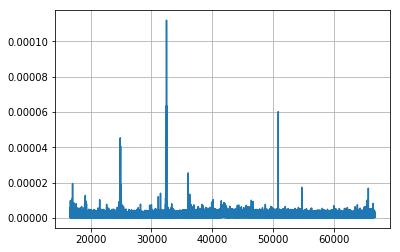

In [119]:
plt.plot(useful_o[40000:160000]/2/np.pi,useful_f[40000:160000]*2);plt.grid()

In [108]:
peaks_frame.index=peaks_frame['freq(Hz)']

In [159]:
"""peak doctor"""
from scipy.optimize import curve_fit
def lorenz(x,x0,sig,a):
    #return a*sig**2/((x-x0)**2+sig**2)
    return a*np.exp(-(x-x0)**2/2/sig**2)

@interact_manual
def peak_doctor(ind=(0,20),width=[2,10,30,100,300,1000,3000,10000,30000]):
    
    peak=peaks_frame.iloc[ind]
    del_f=omega[1]/2/np.pi
    ind_peak=np.int(peak['freq(Hz)']//del_f-2)
    ind_begin=np.int(max(0,ind_peak-width//del_f-1))
    ind_end=np.int(min(ind_peak+width//del_f+1,len(useful_o)-1))
    w=useful_o[ind_begin:ind_end]
    spd=useful_f[ind_begin:ind_end]**2
    plt.bar(useful_o[ind_begin:ind_end]/2/np.pi,useful_f[ind_begin:ind_end],color='grey')
    plt.grid()
    w2=np.linspace(w[0],w[-1],101)
    lorenz0=lorenz(w2,w[len(w)//2],10*del_f,spd[len(spd)//2]/2)
    #plt.plot(w2/np.pi/2,np.sqrt(lorenz0),label="guessed",color='orange')
    param=curve_fit(lorenz,w,spd,[w[len(w)//2],2*del_f,spd[len(spd)//2]/2],maxfev=10000)
    lorenz2=lorenz(w2,*param[0])
    plt.plot(w2/np.pi/2,np.sqrt(lorenz2),label="guessed",color='red')
    print(param[0][0]/np.pi/2,param[0][1]/np.pi/2)
    return peaks_frame.iloc[ind]

interactive(children=(IntSlider(value=10, description='ind', max=20), Dropdown(description='width', options=(2…